In [2]:
def getFinanceData (indicator, startDate, endDate) :
  try :
    data = yf.download(indicator, start=startDate, end=endDate, interval='1mo')
    return data
  except :
      print("An exception occurred")

def cagr ( revenue, montantInvest, dateRange ) :
  return (revenue / montantInvest)**(1/dateRange) - 1

def ratioSharp (rendementMoyen, rendementSansRisque, volatilite) :
  return (rendementMoyen - rendementSansRisque) / volatilite

def volatilite (prix_action) :
  return prix_action.std()

def revenue (montantInitial, montantRecurant, financeTable) :
  montantInvestVariation = [{
      'montantInvest': montantInitial,
      'date': financeTable.index[0]
  }]

  revenueVariation = [
      {
        'revenue': montantInitial,
        'date': financeTable.index[0]
      }
  ]


  montantInvest = montantInitial

  # calcule de rendement
  nbAction = 0

  # le prix d'action au moment d'investisement
  prixAction = financeTable["Adj Close"][0]

  # nombre d'action que on peut acheter
  nbAction = montantInvest // prixAction

  liquidite = montantInvest - (prixAction * nbAction)

  for ind in financeTable.index[1:]:


      # montant qu'on va ivestir ce mois
      montantRecMois = montantRecurant + liquidite

      # prix action lors de l'achat
      prixAction = financeTable["Adj Close"][ind]

      # nombre d'action achetées ce mois
      nbActionAchete = montantRecMois // prixAction

      # nb action total
      nbAction += nbActionAchete

      # liquidité
      liquidite = montantRecMois - nbActionAchete * prixAction

      # mise a jour de montant investi
      montantInvest += montantRecurant

      montantInvestVariation.append({
        'montantInvest': montantInvest,
        'date': ind
      })

      revenueVariation.append({
        'revenue': nbAction * prixAction + liquidite,
        'date': ind
      })


  lastAdjClose = financeTable["Adj Close"][-1]
  revenue = nbAction * lastAdjClose + liquidite
  rendementMoyen = (revenue / montantInvest) - 1

  return {'montantInvest': montantInvest, 'revenue': revenue, 'rendementMoyen': rendementMoyen, 'montantInvestVariation': montantInvestVariation, 'revenueVariation': revenueVariation}


def ecartInterquartille (df) :
  # calcule de l'ecart interquartille
  quartiles = df["Close"].quantile([0.25, 0.75])
  iqr = quartiles[0.75] - quartiles[0.25]
  return iqr

def ecartType (df) :
  return df.std()

def moyenne (df) :
  return df.mean()

In [3]:
import pandas as pd
import yfinance as yf

# données
montantInitial = 10_000
montantRecurant = 500

start = "2010-01-01"
end = "2023-01-25"

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
INDICATOR = "ACWI"

applData = getFinanceData(INDICATOR, start, end)

applData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,43.110001,43.880001,39.950001,40.049999,29.920282,4429100
2010-02-01,40.410000,41.459999,38.689999,40.919998,30.570238,3098300
2010-03-01,41.169998,43.810001,41.090000,43.509998,32.505146,8735900
2010-04-01,44.110001,45.310001,43.080002,43.410000,32.430447,6345200
2010-05-01,43.779999,44.000000,37.340000,39.340000,29.389854,7668000


In [5]:
applData.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-01,85.209999,88.989998,77.769997,77.830002,75.732353,115638500
2022-10-01,78.660004,83.440002,75.709999,82.769997,80.539207,104607300
2022-11-01,83.980003,89.669998,79.849998,89.669998,87.253235,122598300
2022-12-01,90.089996,90.370003,83.589996,84.879997,82.592331,120645500
2023-01-01,85.510002,91.809998,84.400002,91.250000,89.477058,132519400


In [6]:
# calcule de revenue
revenueStats = revenue(montantInitial, montantRecurant, applData)

# calcule de cagr
dateRange = applData.index[-1].year - applData.index[0].year
cagrAppl = cagr(revenueStats['revenue'], revenueStats['montantInvest'], dateRange)

# calcule de volatilite
volatiliteAppl = volatilite(applData['Adj Close'])

# calcule de ratio de sharp
rendementSansRisque = 0.03
ratioSharpAppl = ratioSharp (revenueStats['rendementMoyen'], rendementSansRisque, volatiliteAppl)

# calcule de la moyenne
moyenneAppl = moyenne(applData['Adj Close'])

ratioSharpAppl

0.04436622498255989

In [7]:
INDICATOR_TSLA = "CW8.PA"

teslaData = getFinanceData(INDICATOR_TSLA, start, end)

teslaData.head()


# calcule de revenue
revenueStatsTsla = revenue(montantInitial, montantRecurant, teslaData)

# calcule de cagr
dateRange = teslaData.index[-1].year - teslaData.index[0].year
cagrTsla = cagr(revenueStatsTsla['revenue'], revenueStatsTsla['montantInvest'], dateRange)

# calcule de volatilite
volatiliteTsla = volatilite(teslaData['Adj Close'])

# calcule de ratio de sharp
rendementSansRisque = 0.03
ratioSharpTsla = ratioSharp (revenueStatsTsla['rendementMoyen'], rendementSansRisque, volatiliteTsla)

# calcule de la moyenne
moyenneTsla = moyenne(teslaData['Adj Close'])

ratioSharpTsla

[*********************100%%**********************]  1 of 1 completed


0.01314464143497968

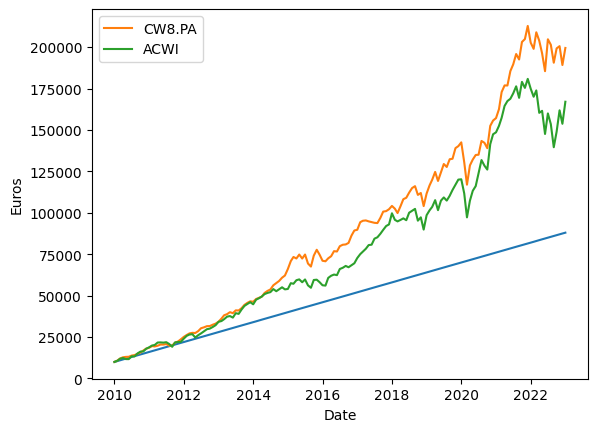

In [8]:
from matplotlib import pyplot

# plot de montant investi
xInvest = [i['date'] for i in revenueStats['montantInvestVariation']]
yInvest = [i['montantInvest'] for i in revenueStats['montantInvestVariation']]

pyplot.plot(xInvest, yInvest)

# plot de revenue tesla
xTsla = [i['date'] for i in revenueStatsTsla['revenueVariation']]
yTsla = [i['revenue'] for i in revenueStatsTsla['revenueVariation']]

pyplot.plot(xTsla, yTsla, label = INDICATOR_TSLA)

# plot de revenue apple
xApple = [i['date'] for i in revenueStats['revenueVariation']]
yApple = [i['revenue'] for i in revenueStats['revenueVariation']]

pyplot.plot(xApple, yApple, label = INDICATOR)

pyplot.xlabel('Date')
pyplot.ylabel('Euros')

pyplot.legend()

pyplot.show()

In [9]:
print(f'                            {INDICATOR} | {INDICATOR_TSLA}')
print('Montant investi ', revenueStats['montantInvest'],'€         |' ,revenueStatsTsla['montantInvest'], '€')
print('Revenue         ', revenueStats['revenue'],'€     |' , revenueStatsTsla['revenue'], '€')
print('CAGR            ', (cagrAppl) * 100,'%          |' , (cagrTsla) * 100, '%')
print('Rendement            ', (revenueStats['rendementMoyen']) * 100,'%          |' , (revenueStatsTsla['rendementMoyen']) * 100, '%')

                            ACWI | CW8.PA
Montant investi  88000 €         | 88000 €
Revenue          167022.40088272095 €     | 199493.09702301025 €
CAGR             5.0526665990225705 %          | 6.498119314809014 %
Rendement             89.79818282127381 %          | 126.69670116251166 %


In [10]:
applData.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-01,43.110001,43.880001,39.950001,40.049999,29.920282,4429100
2010-02-01,40.410000,41.459999,38.689999,40.919998,30.570238,3098300
2010-03-01,41.169998,43.810001,41.090000,43.509998,32.505146,8735900
2010-04-01,44.110001,45.310001,43.080002,43.410000,32.430447,6345200
2010-05-01,43.779999,44.000000,37.340000,39.340000,29.389854,7668000


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

# Assuming 'df' is your DataFrame with the provided dataset
df = applData
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']

# Split the data into training and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model (e.g., using mean squared error)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
r_squared = r2_score(y_test, y_pred)
print('R-squared:', r_squared)


Mean Squared Error: 1.2496470000473552
R-squared: 0.996151932082482


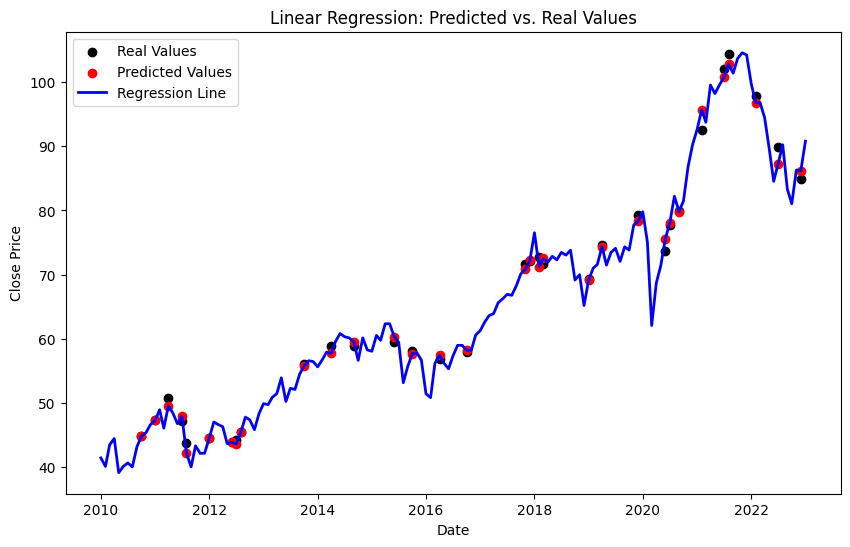

In [12]:
# Get dates for the test set
dates_test = pd.to_datetime(X_test.index)

import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for real values
plt.scatter(dates_test, y_test, color='black', label='Real Values')

# Scatter plot for predicted values
plt.scatter(dates_test, y_pred, color='red', label='Predicted Values')

# Regression line
# regression_line = model.intercept_ + np.sum(model.coef_ * X_test, axis=1)
# plt.plot(dates_test, regression_line, color='blue', linewidth=2, label='Regression Line')

regression_line_dates = pd.to_datetime(X.index)  # Use all dates for the regression line
regression_line_values = model.intercept_ + np.sum(model.coef_ * X, axis=1)
plt.plot(regression_line_dates, regression_line_values, color='blue', linewidth=2, label='Regression Line')


# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression: Predicted vs. Real Values')
plt.legend()

# Show the plot
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

# Assuming 'df' is your DataFrame with the provided dataset
df = applData

df.to_csv('data.csv')

df = pd.read_csv('data.csv')

In [14]:
df['Date'] = pd.to_datetime(df['Date'])

df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [15]:
df = df[['Date', 'Close']]
df

,Date,Close
0,2010-01-01,40.049999
1,2010-02-01,40.919998
2,2010-03-01,43.509998
3,2010-04-01,43.410000
4,2010-05-01,39.340000
...,...,...
152,2022-09-01,77.830002
153,2022-10-01,82.769997
154,2022-11-01,89.669998
155,2022-12-01,84.879997


19.564022599487263


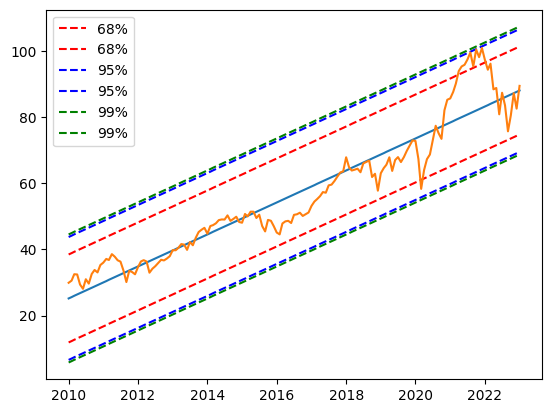

In [16]:
import numpy as np
from matplotlib import pyplot

df = applData.copy()

df['Time'] = np.arange(len(applData.index))
df = df[['Time', 'Adj Close']]

df.head()
from sklearn.linear_model import LinearRegression

df['Time'] = np.arange(len(df.index))
df = df[['Time', 'Adj Close']]

x = df.loc[:, ['Time']]  # features
y = df.loc[:, 'Adj Close']  # target

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(x), index=x.index)

std = df['Adj Close'].std()
print(std)

upper_bound = y_pred + 0.68 * std
lower_bound = y_pred - 0.68 * std

std68Up = pd.Series(upper_bound, index=x.index)
std68Dn = pd.Series(lower_bound, index=x.index)

pyplot.plot(std68Dn, linestyle='dashed', label='68%', color='red')
pyplot.plot(std68Up, linestyle='dashed', label='68%', color='red')

upper_bound = y_pred + 0.95 * std
lower_bound = y_pred - 0.95 * std

std68Up = pd.Series(upper_bound, index=x.index)
std68Dn = pd.Series(lower_bound, index=x.index)

pyplot.plot(std68Dn, linestyle='dashed', label='95%', color='blue')
pyplot.plot(std68Up, linestyle='dashed', label='95%', color='blue')

upper_bound = y_pred + 0.99 * std
lower_bound = y_pred - 0.99 * std

std68Up = pd.Series(upper_bound, index=x.index)
std68Dn = pd.Series(lower_bound, index=x.index)

pyplot.plot(std68Dn, linestyle='dashed', label='99%', color='green')
pyplot.plot(std68Up, linestyle='dashed', label='99%', color='green')

# Store the fitted values as a time series with the same time index as
# the training data
pyplot.plot(y_pred)
pyplot.plot(df.index, df['Adj Close'])

pyplot.legend()

# Nouvelle section

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')


Mean Squared Error (MSE): 32.88749338701875
R-squared (R2): 0.9056557633400171
